# Linear Classifier with Pytorch


Our goal is to train a Linear Classifier to be able to classify handwritten digits using the MNIST dataset.

This classifier will be a neural network composed of a single layer of 10 neurons that use the softmax activation function to output the probabilities that a certain digits belongs to a specific class.
The input consists of 784 features, each representing one pixel of a 28 x 28 image.


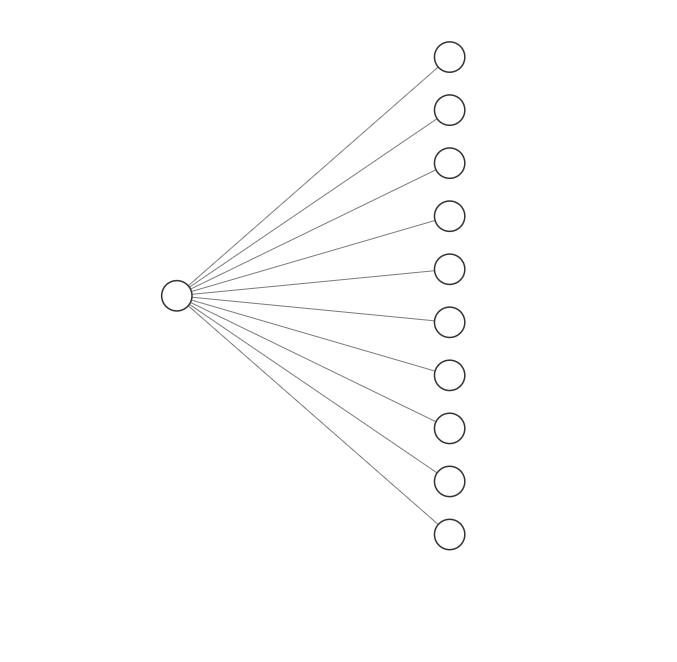

Diagram made with: https://alexlenail.me/NN-SVG/index.html

This notebook contains several ways of making a Linear classsifier in pytorch, mostly followed from the pytorch documentation itself.

Our linear classifier will have the following form:

$\hat{y} = softmax(\mathbf{x} \mathbf{W} + \mathbf{b})$

$W$ will be our weight matrix of shape (784, 10) and $b$ is a bias of shape (10). When we realize the above operation we will have a vector of 10 values to which we will apply the softmax function to turn those values into probabilities. The index of the highest value will correspond to the predicted class for a specific input. This is our single layer in our network. To end up with probabilities we apply the softmax function to the ten outputs. 

This notebooks shows the model being trained using the negative log likelihood as the loss function and, at the end, shows the network trained using the mean squared error loss, whose formula is given by

$$ MSE = \frac{1}{m}\sum (y - \hat{y})^2$$

Sources:

https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html

ChatGPT GPT-5  and Gemini for more conceptual understanding

ChatGPT with GPT-5 and GPT-4o for help with LaTeX formatting.

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [184]:
# load the numpy array and convert it to a tensor
data = np.load("images_array.npy")
labels = np.load("labels_array.npy")


In [185]:
# data has shape (60_000, 784)
# labels has shape (60_000)
data = torch.from_numpy(data)
labels = torch.from_numpy(labels)

In [186]:
from utilities import train_test_split

In [187]:
# convert data to float 32 and do a train test split
data = data.type(torch.float32)
labels = labels.type(torch.long)
x_train, y_train, x_test, y_test = train_test_split(data, labels, train_size=0.7)

In [188]:
n, c = x_train.shape #rows and cols of x_train
x_train.shape

torch.Size([44462, 784])

In [189]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
# setting `requires_grad` has to be done after the initialization, otherwise the initialization would be recorded
weights.requires_grad_() # in place operation, this will allows us to calculate the gradient later on
bias = torch.zeros(10, requires_grad = True)

In [190]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1) 

def model(xb):
    return log_softmax(xb @ weights + bias)

In [191]:

bs = 64 # batch size

xb = x_train[0:bs] # a mini batch from x
preds = model(xb) # predictions
preds[0], preds.shape
print(preds[0], preds.shape)


tensor([-1.8775, -2.4361, -2.6194, -2.2347, -2.4409, -2.1480, -2.3696, -2.3026,
        -2.1862, -2.6594], grad_fn=<SelectBackward0>) torch.Size([64, 10])


## Loss Function

Purpose: The loss function will calculate how wrong we are in our prediction. 


explanation of code snippet:

```
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll
```

This code snippet defines our loss function.
the input will be the predictions made from the forward pass of the neural net. Our prediction tensor will be composed of n rows representing the images, and will have 10 columns representing the probability of each digit. So, in our loss function we select from all rows the probability that was assigned to the actual label. 


Using this loss function, we can do backpropragation which will update our weights and bias.

In [192]:
# implement a negative log likelihood to use as the loss function
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [193]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(1.9954, grad_fn=<NegBackward0>)


In [194]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim = 1)
    return (preds == yb).float().mean()

In [195]:
print(accuracy(preds, yb))

tensor(0.4844)


### Training Loop

In the training loop we subdivide the dataset into groups called batches. We compute predictions on a batch, then compute the loss using our predictions and the actual target label. Then, we compute the the gradient and update the weights and bias. 

In [196]:

lr = 0.5 # learning rate
epochs = 2 # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward() # update gradients of the model, (i.e weights and bias)
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

# this is a neural network using logistic regression since we don't have hidden layers.

In [ ]:
# loss and accuracy tested on the latest batch
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0025, grad_fn=<NegBackward0>) tensor(1.)


In [ ]:
# the loss and the accuracy on the test set
print(loss_func(model(x_test), y_test), accuracy(model(x_test), y_test))

tensor(7.2043, grad_fn=<NegBackward0>) tensor(0.2229)


# Using `torch.nn.functional`

In [37]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [ ]:
loss_func(model(xb), yb.type(torch.long))

tensor(8.9704e-06, grad_fn=<NllLossBackward0>)

# Refactor using `nn.Module`

"Use nn.Module and nn.Parameter for a clearer and more concise training loop.
we subclass nn.Module which itself is a class and able to keep track of state. In this case, we want to create a class that holds our weights and bias, and method for the forward step. nn.Module has a number of attributs and methods (such as .parameters() and .zero_grad()) "

source: https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html

In [39]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias
    

In [40]:
model = Mnist_Logistic()

In [41]:
yb = yb.type(torch.long)

In [42]:
print(loss_func(model(xb), yb))

tensor(2.3340, grad_fn=<NllLossBackward0>)


In [43]:
def fit(epochs = 2, lr = 0.5, bs=64):
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit(2, 0.25)

In [44]:
print(loss_func(model(xb), yb))

tensor(0.0010, grad_fn=<NllLossBackward0>)


In [45]:
accuracy(model(x_test), y_test)

tensor(0.2002)

In [46]:
accuracy(model(x_train), y_train)

tensor(0.2029)

# Refactor using `nn.Linear`

In [131]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        self.sf = nn.Softmax()


    def forward(self, xb):
        x= self.lin(xb)
        x = self.sf(x)
        return x

        


In [48]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.1644, grad_fn=<NllLossBackward0>)


In [49]:
# we can still use the same fit method:

fit()
print(loss_func(model(xb), yb))

tensor(1.1235e-05, grad_fn=<NllLossBackward0>)


In [75]:
loss_func = nn.MSELoss()

In [ ]:
def train_model(model, optimizer, criterion, bs = 32, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            images = x_train[start_i:end_i] # get 'batch size' number of samples
            labels = y_train[start_i:end_i]
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1):.4f}")

In [83]:
y_train = y_train.type(torch.long)

In [ ]:
# one hot encode labels to use with MSE loss
def one_hot_encode(labels):
    one_hot = torch.zeros(labels.shape[0], 10)
    for row, col in enumerate(labels):
        one_hot[row, int(col.item())] = 1
    return one_hot

y_train = one_hot_encode(y_train)



In [ ]:
y_train[0] # First label in the training set. The 1 at position 0 means the label for this sample is 0.

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# Initialize a new model and train it for 50 epochs using mse_loss
model = Mnist_Logistic()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.7)
loss_func = F.mse_loss
train_model(model, optimizer, criterion=loss_func, num_epochs=50)


c:\Users\carlo\anaconda3\envs\csc4444\Lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1, Loss: 0.0650
Epoch 2, Loss: 0.0439
Epoch 3, Loss: 0.0336
Epoch 4, Loss: 0.0282
Epoch 5, Loss: 0.0251
Epoch 6, Loss: 0.0232
Epoch 7, Loss: 0.0218
Epoch 8, Loss: 0.0208
Epoch 9, Loss: 0.0200
Epoch 10, Loss: 0.0194
Epoch 11, Loss: 0.0188
Epoch 12, Loss: 0.0184
Epoch 13, Loss: 0.0180
Epoch 14, Loss: 0.0177
Epoch 15, Loss: 0.0174
Epoch 16, Loss: 0.0172
Epoch 17, Loss: 0.0169
Epoch 18, Loss: 0.0167
Epoch 19, Loss: 0.0165
Epoch 20, Loss: 0.0164
Epoch 21, Loss: 0.0162
Epoch 22, Loss: 0.0160
Epoch 23, Loss: 0.0159
Epoch 24, Loss: 0.0158
Epoch 25, Loss: 0.0156
Epoch 26, Loss: 0.0155
Epoch 27, Loss: 0.0154
Epoch 28, Loss: 0.0153
Epoch 29, Loss: 0.0152
Epoch 30, Loss: 0.0151
Epoch 31, Loss: 0.0150
Epoch 32, Loss: 0.0150
Epoch 33, Loss: 0.0149
Epoch 34, Loss: 0.0148
Epoch 35, Loss: 0.0147
Epoch 36, Loss: 0.0147
Epoch 37, Loss: 0.0146
Epoch 38, Loss: 0.0145
Epoch 39, Loss: 0.0145
Epoch 40, Loss: 0.0144
Epoch 41, Loss: 0.0143
Epoch 42, Loss: 0.0143
Epoch 43, Loss: 0.0142
Epoch 44, Loss: 0.01

In [ ]:
def decode(y_data):
    # turn back numerical values
    labels = torch.zeros( y_data.shape[0])

    for i in range(y_data.shape[0]):
        labels[i] = (np.where(y_data[i] == 1))[0].item()
    
    return labels

In [157]:
labels = decode(y_train)

torch.Size([44420])


In [158]:

def evaluate(model, x_data, y_data):
    model.eval()
    with torch.no_grad():
        outputs = model(x_data)
        _, predicted = torch.max(outputs.data, 1)
        total = y_data.size(0)
        correct = (predicted == np.where(y_data==1)[1]).sum().item()
    return correct / total

In [ ]:
# probabilities of the sample belonging to each class. 
model(x_train[0])

c:\Users\carlo\anaconda3\envs\csc4444\Lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([9.8885e-01, 2.6512e-07, 1.4251e-04, 2.8024e-04, 1.0054e-06, 9.4801e-03,
        1.2877e-04, 2.7197e-04, 7.8990e-04, 5.9361e-05],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
# model evaluated on training data
evaluate(model, x_train, y_train)

(0.8756641152633948, None)

In [ ]:
# alternative 'evaluate' function provided by chatgpt which works on both integer and one hot encoded labels
def evaluate(model, x_data, y_data, criterion=None, batch_size=1024, device=None):
    """
    Returns (accuracy, avg_loss) where avg_loss is None if criterion is None.
    Works with integer labels (shape [N]) or one-hot labels (shape [N, num_classes]).
    """
    import torch
    model.eval()
    if device is None:
        try:
            device = next(model.parameters()).device
        except StopIteration:
            device = torch.device('cpu')
    total = 0
    correct = 0
    running_loss = 0.0
    with torch.no_grad():
        for i in range(0, x_data.size(0), batch_size):
            xb = x_data[i:i+batch_size].to(device)
            yb = y_data[i:i+batch_size]
            if isinstance(yb, np.ndarray):
                yb = torch.from_numpy(yb)
            yb = yb.to(device)

            outputs = model(xb)                     # logits or raw outputs
            preds = outputs.argmax(dim=1)          # predicted class

            # convert yb to integer class labels for accuracy
            if yb.dim() == 2 and yb.size(1) == outputs.size(1):
                labels = yb.argmax(dim=1)
            else:
                labels = yb.view(-1).long()

            correct += (preds == labels).sum().item()
            batch_n = labels.size(0)
            total += batch_n

            if criterion is not None:
                # if criterion is MSE and labels are ints, convert to one-hot
                if (isinstance(criterion, torch.nn.MSELoss) or getattr(criterion, "__name__", "") == "mse_loss"):
                    target_for_loss = labels if (yb.dim() == 2 and yb.size(1) == outputs.size(1)) else torch.nn.functional.one_hot(labels, num_classes=outputs.size(1)).float().to(device)
                    running_loss += criterion(outputs, target_for_loss).item() * batch_n
                else:
                    running_loss += criterion(outputs, labels).item() * batch_n

    acc = correct / total if total > 0 else 0.0
    avg_loss = (running_loss / total) if (criterion is not None and total > 0) else None
    return acc, avg_loss

With 50 epochs, we see an accuracy of $86.85\%$

In [ ]:
# model evaluated on test data
evaluate(model, x_test, y_test, criterion=nn.MSELoss())

(0.8685, 0.01933759235839049)